# Assignment 4 - Neural Networks
Emma Mavis  
egm28  
*Worked with: Sydney Donati-Leach*

## 1. Exploring and Optimizing Neural Network Hyperparameters

In [1]:
import numpy as np
from sklearn.model_selection import (
    PredefinedSplit,
    RandomizedSearchCV,
    train_test_split,
)
import sys
import os
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from scipy.stats import loguniform
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Optional for clear plotting on Macs
%config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with 
#  what's causing the warning and simply don't want to see it, we can use the 
#  following code. Run this block
#  to disable warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'

In [3]:
# -----------------------------------------------------------------------------
# Create the data
# -----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n / 4)
    shift = 0.5
    c1a = np.random.randn(n_samples, 2) * noise + [-shift, shift]
    c1b = np.random.randn(n_samples, 2) * noise + [shift, -shift]
    c0a = np.random.randn(n_samples, 2) * noise + [shift, shift]
    c0b = np.random.randn(n_samples, 2) * noise + [-shift, -shift]
    X = np.concatenate((c1a, c1b, c0a, c0b), axis=0)
    y = np.concatenate((np.ones(2 * n_samples), np.zeros(2 * n_samples)))

    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X) > cutoff
    for index, value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand() * 2.5 - 1.25
    return (X, y)


# Training datasets
np.random.seed(42)
noise = 0.45
X_train, y_train = make_data_normal_checkerboard(500, noise=noise)

# Validation and test data
X_val, y_val = make_data_normal_checkerboard(500, noise=noise)
X_test, y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSeachCV, we will need to combine training and validation 
# sets then specify which portion is training and which is validation
# Also, for the final performance evaluation, 
# train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate(
    (-1 * np.ones(len(y_train)), np.zeros(len(y_val)))
)
train_val_split = PredefinedSplit(validation_fold)


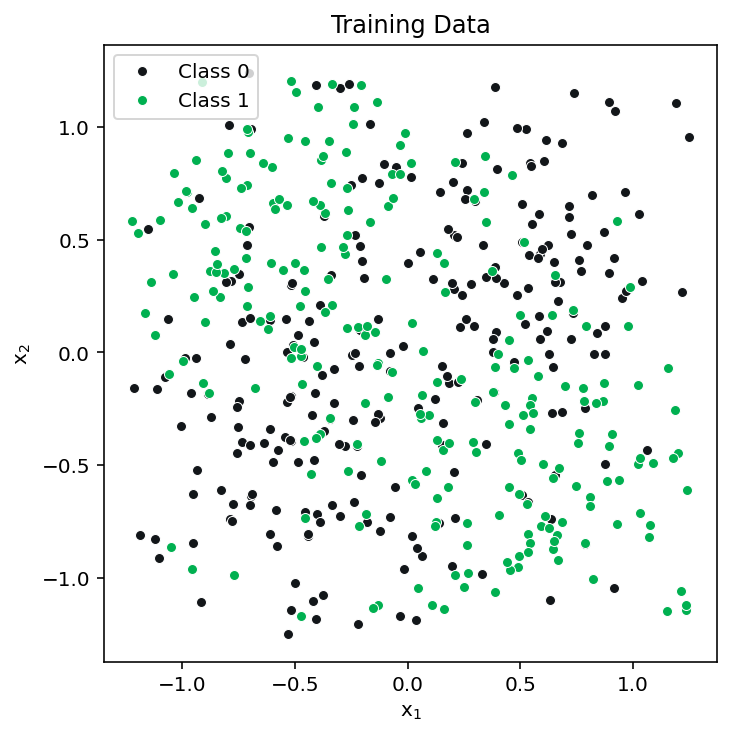

In [49]:
# Code to plot the sample data
def plot_data(ax, X, y, title, limits):
    # Select the colors to use in the plots
    color0 = "#121619"  # Dark grey
    color1 = "#00B050"  # Green
    color_boundary = "#858585"

    # Separate samples by class
    samples0 = X[y == 0]
    samples1 = X[y == 1]

    ax.plot(
        samples0[:, 0],
        samples0[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 0",
    )
    ax.plot(
        samples1[:, 0],
        samples1[:, 1],
        marker="o",
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor="w",
        markeredgewidth=0.5,
        label="Class 1",
    )
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.legend(loc="upper left")
    ax.set_aspect("equal")


fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, "Training Data", limits)


**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries**
- Vary the architecture (hidden_layer_sizes) by changing number of nodes, but keeping number of layers constant at two.

In [6]:
clf00 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(2, 2),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)
clf01 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(5, 5),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)
clf02 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)


- Vary the learning rate (learning_rate_init)

In [7]:
clf10 = MLPClassifier(
    learning_rate_init=0.0001,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)
clf11 = MLPClassifier(
    learning_rate_init=0.01,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)
clf12 = MLPClassifier(
    learning_rate_init=1,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)


- Vary the regularization (alpha)

In [8]:
clf20 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)
clf21 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(30, 30),
    alpha=1,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)
clf22 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(30, 30),
    alpha=10,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)


- Vary the batch size (batch_size)

In [9]:
clf30 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=5,
    max_iter=500,
).fit(X_train, y_train)
clf31 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=50,
    max_iter=500,
).fit(X_train, y_train)
clf32 = MLPClassifier(
    learning_rate_init=0.03,
    hidden_layer_sizes=(30, 30),
    alpha=0,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=500,
    max_iter=500,
).fit(X_train, y_train)


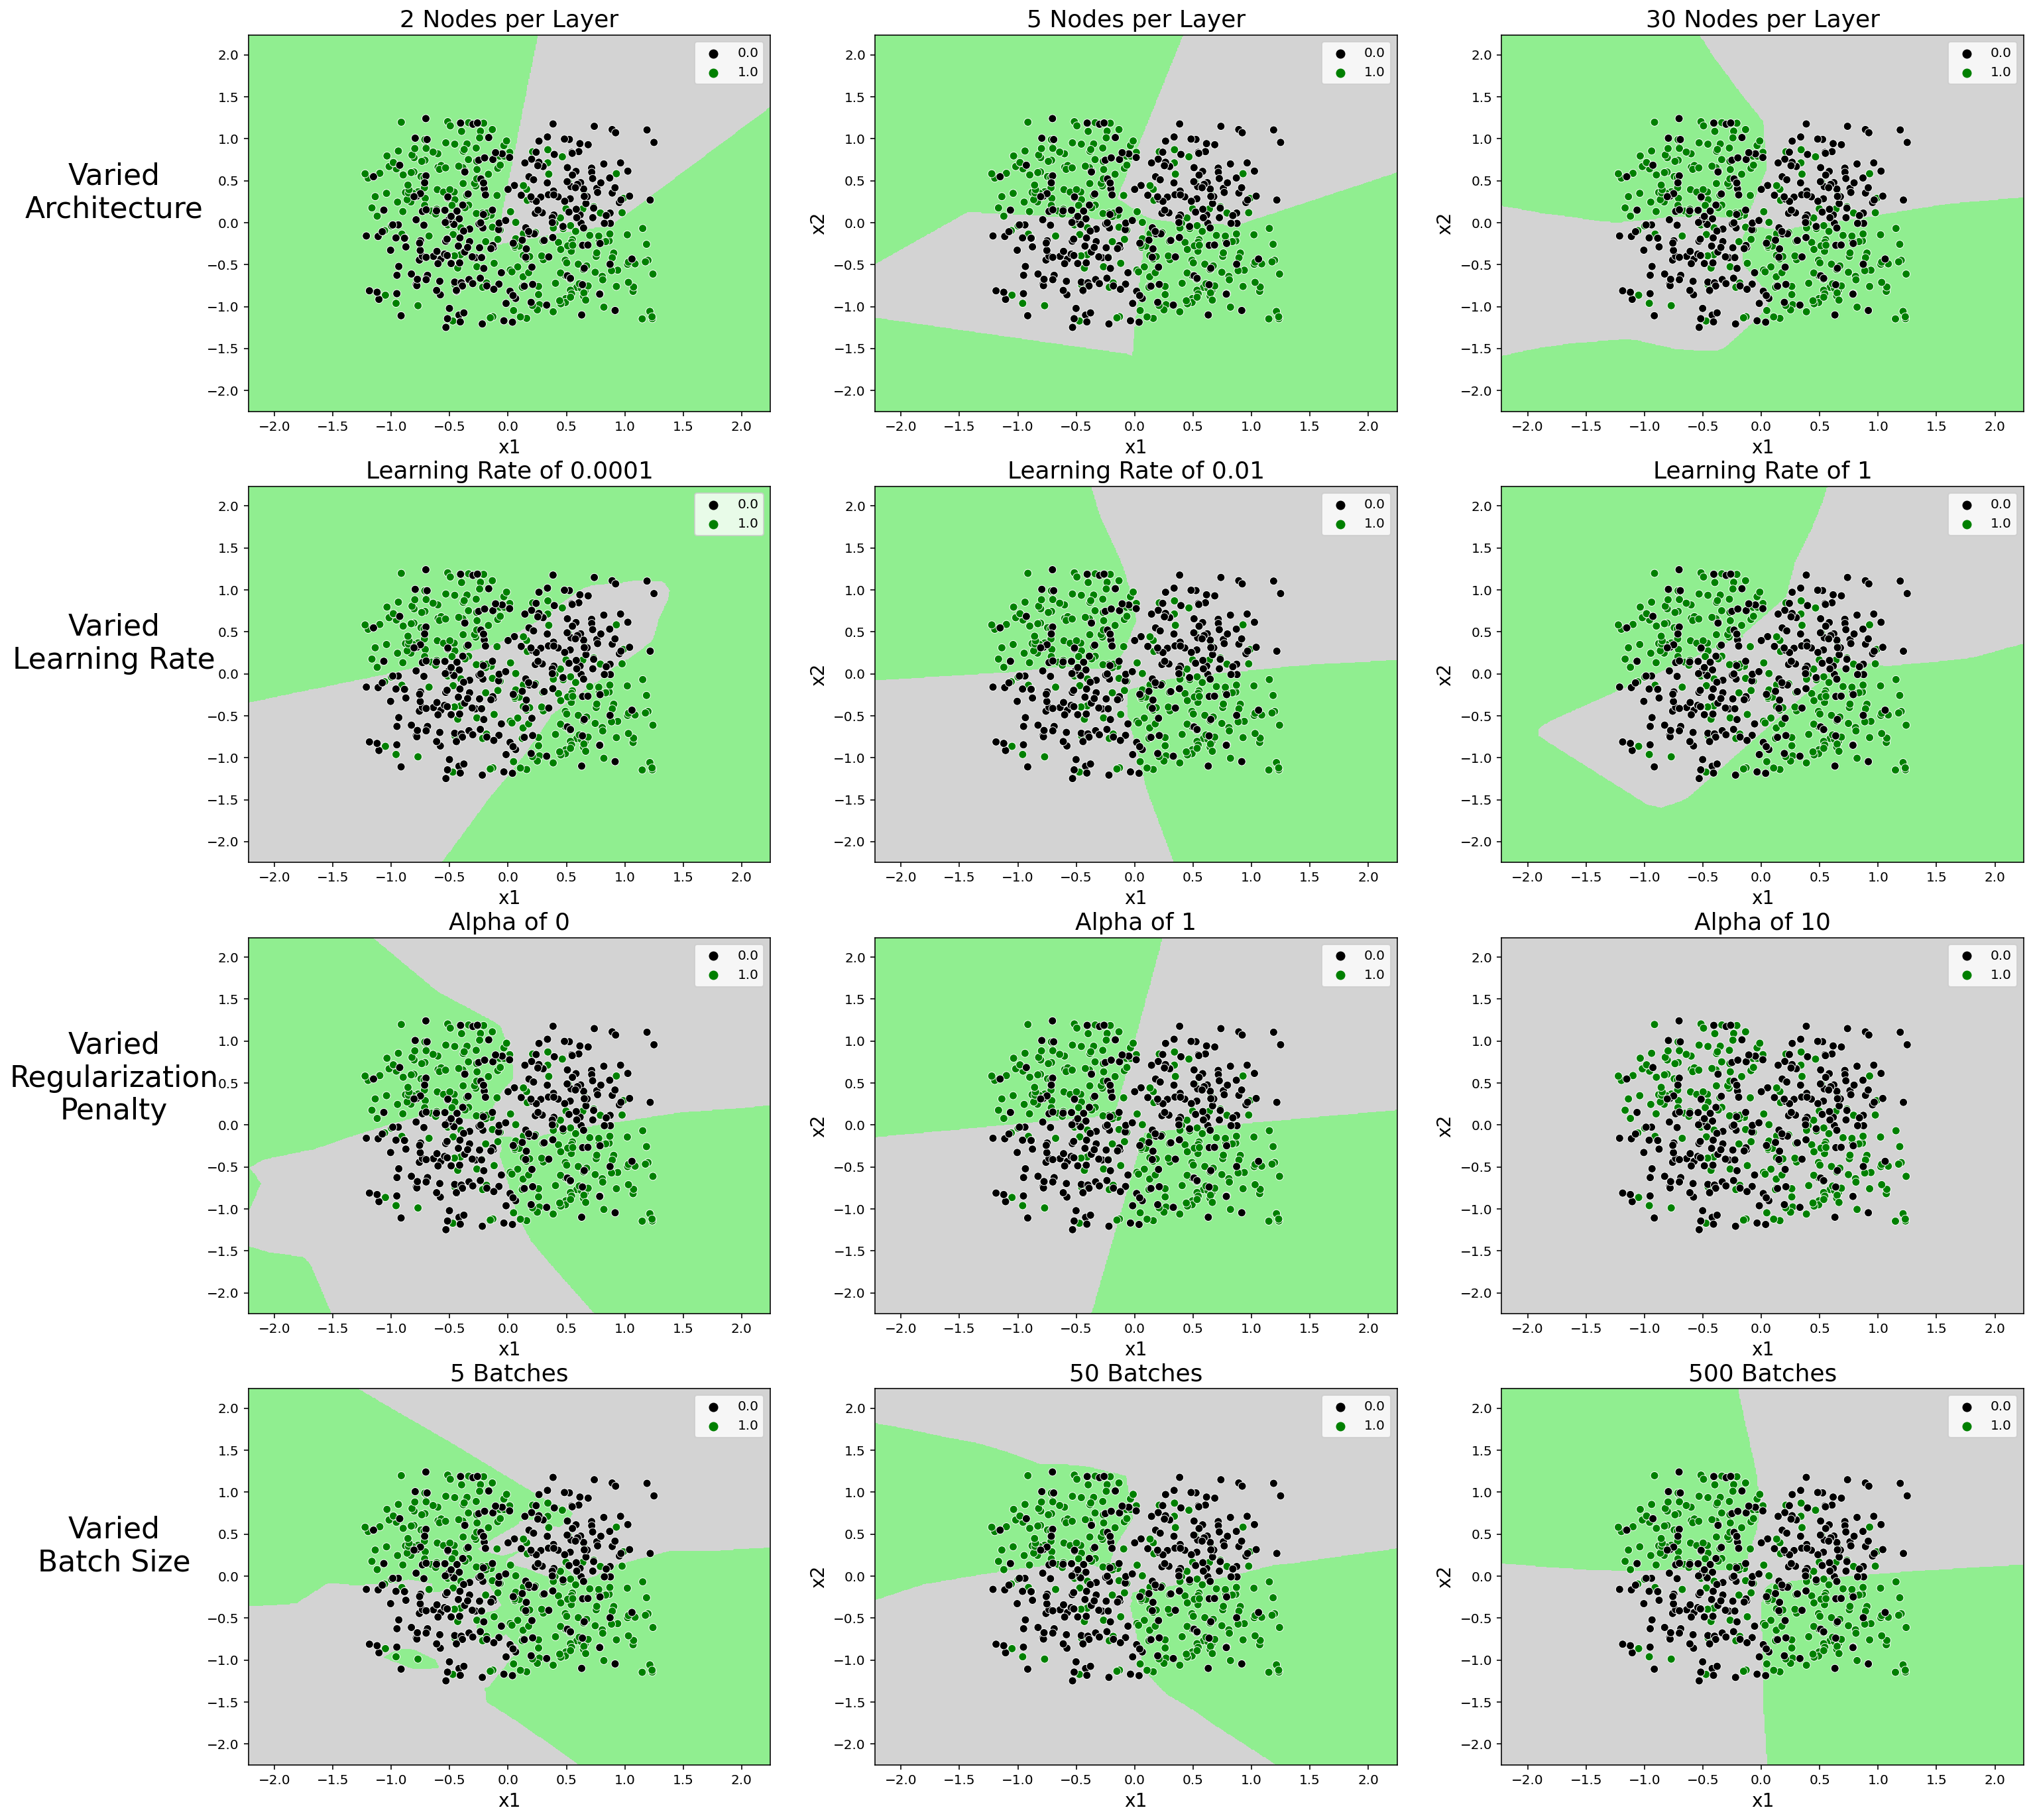

In [10]:
# create array of models for easier iteration
model_array = np.array(
    [
        [clf00, clf01, clf02],
        [clf10, clf11, clf12],
        [clf20, clf21, clf22],
        [clf30, clf31, clf32],
    ]
)

ncols = 3
nrows = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(24, 24))

# create meshgrid
cmap_light = ListedColormap(["lightgrey", "lightgreen"])
h = 0.01
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(
    np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h)
)
Z = np.c_[xx1.ravel(), xx2.ravel()]

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        # create decision boundary
        boundary = model_array[i][j].predict(Z).reshape(xx1.shape)
        ax.contourf(xx1, xx2, boundary, cmap=cmap_light)
        # plot training data
        sns.scatterplot(
            ax=ax,
            x=X_train[:, 0],
            y=X_train[:, 1],
            hue=y_train,
            palette=["black", "green"],
        )

axs[0][0].set_ylabel(
    "Varied\nArchitecture", size=22, rotation=0, labelpad=70
)
axs[0][0].set_xlabel("x1", size=14)
axs[0][0].set_title("2 Nodes per Layer", size=18)
axs[0][1].set_xlabel("x1", size=14)
axs[0][1].set_ylabel("x2", size=14)
axs[0][1].set_title("5 Nodes per Layer", size=18)
axs[0][2].set_xlabel("x1", size=14)
axs[0][2].set_ylabel("x2", size=14)
axs[0][2].set_title("30 Nodes per Layer", size=18)

axs[1][0].set_ylabel(
    "Varied\nLearning Rate", size=22, rotation=0, labelpad=70
)
axs[1][0].set_xlabel("x1", size=14)
axs[1][0].set_title("Learning Rate of 0.0001", size=18)
axs[1][1].set_xlabel("x1", size=14)
axs[1][1].set_ylabel("x2", size=14)
axs[1][1].set_title("Learning Rate of 0.01", size=18)
axs[1][2].set_xlabel("x1", size=14)
axs[1][2].set_ylabel("x2", size=14)
axs[1][2].set_title("Learning Rate of 1", size=18)

axs[2][0].set_ylabel(
    "Varied\nRegularization\nPenalty",
    size=22,
    rotation=0,
    labelpad=70,
)
axs[2][0].set_xlabel("x1", size=14)
axs[2][0].set_title("Alpha of 0", size=18)
axs[2][1].set_xlabel("x1", size=14)
axs[2][1].set_ylabel("x2", size=14)
axs[2][1].set_title("Alpha of 1", size=18)
axs[2][2].set_xlabel("x1", size=14)
axs[2][2].set_ylabel("x2", size=14)
axs[2][2].set_title("Alpha of 10", size=18)

axs[3][0].set_ylabel(
    "Varied\nBatch Size", size=22, rotation=0, labelpad=70
)
axs[3][0].set_xlabel("x1", size=14)
axs[3][0].set_title("5 Batches", size=18)
axs[3][1].set_xlabel("x1", size=14)
axs[3][1].set_ylabel("x2", size=14)
axs[3][1].set_title("50 Batches", size=18)
axs[3][2].set_xlabel("x1", size=14)
axs[3][2].set_ylabel("x2", size=14)
axs[3][2].set_title("500 Batches", size=18)

plt.show()


**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time**
- Vary learning rate logarithmically from $10^{-5}$ to $10^0$ with 20 steps.

In [4]:
random.seed(1)
learning_rates = np.logspace(-5, 0, 20)
lr_accuracy_scores = []
for lr in learning_rates:
    mlp = MLPClassifier(
        learning_rate_init=lr,
        hidden_layer_sizes=(30, 30),
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=100,
        batch_size=50,
        max_iter=500,
    ).fit(X_train, y_train)
    lr_accuracy_scores.append(mlp.score(X_val, y_val))
    pass


- Vary regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps.

In [13]:
regularizations = np.logspace(-8, 2, 20)
reg_accuracy_scores = []
for reg in regularizations:
    mlp = MLPClassifier(
        learning_rate_init=0.03,
        hidden_layer_sizes=(30, 30),
        alpha=reg,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=100,
        batch_size=50,
        max_iter=500,
    ).fit(X_train, y_train)
    reg_accuracy_scores.append(mlp.score(X_val, y_val))
    pass


- Vary the batch size over the following values: $[1, 3, 5, 10, 20, 50, 100, 250, 500]$.

In [6]:
batch_sizes = [1, 3, 5, 10, 20, 50, 100, 250, 500]
batch_accuracy_scores = []
for batch in batch_sizes:
    mlp = MLPClassifier(
        learning_rate_init=0.03,
        hidden_layer_sizes=(30, 30),
        alpha=0,
        solver="sgd",
        tol=1e-5,
        early_stopping=False,
        activation="relu",
        n_iter_no_change=100,
        batch_size=batch,
        max_iter=500,
    ).fit(X_train, y_train)
    batch_accuracy_scores.append(mlp.score(X_val, y_val))
    pass


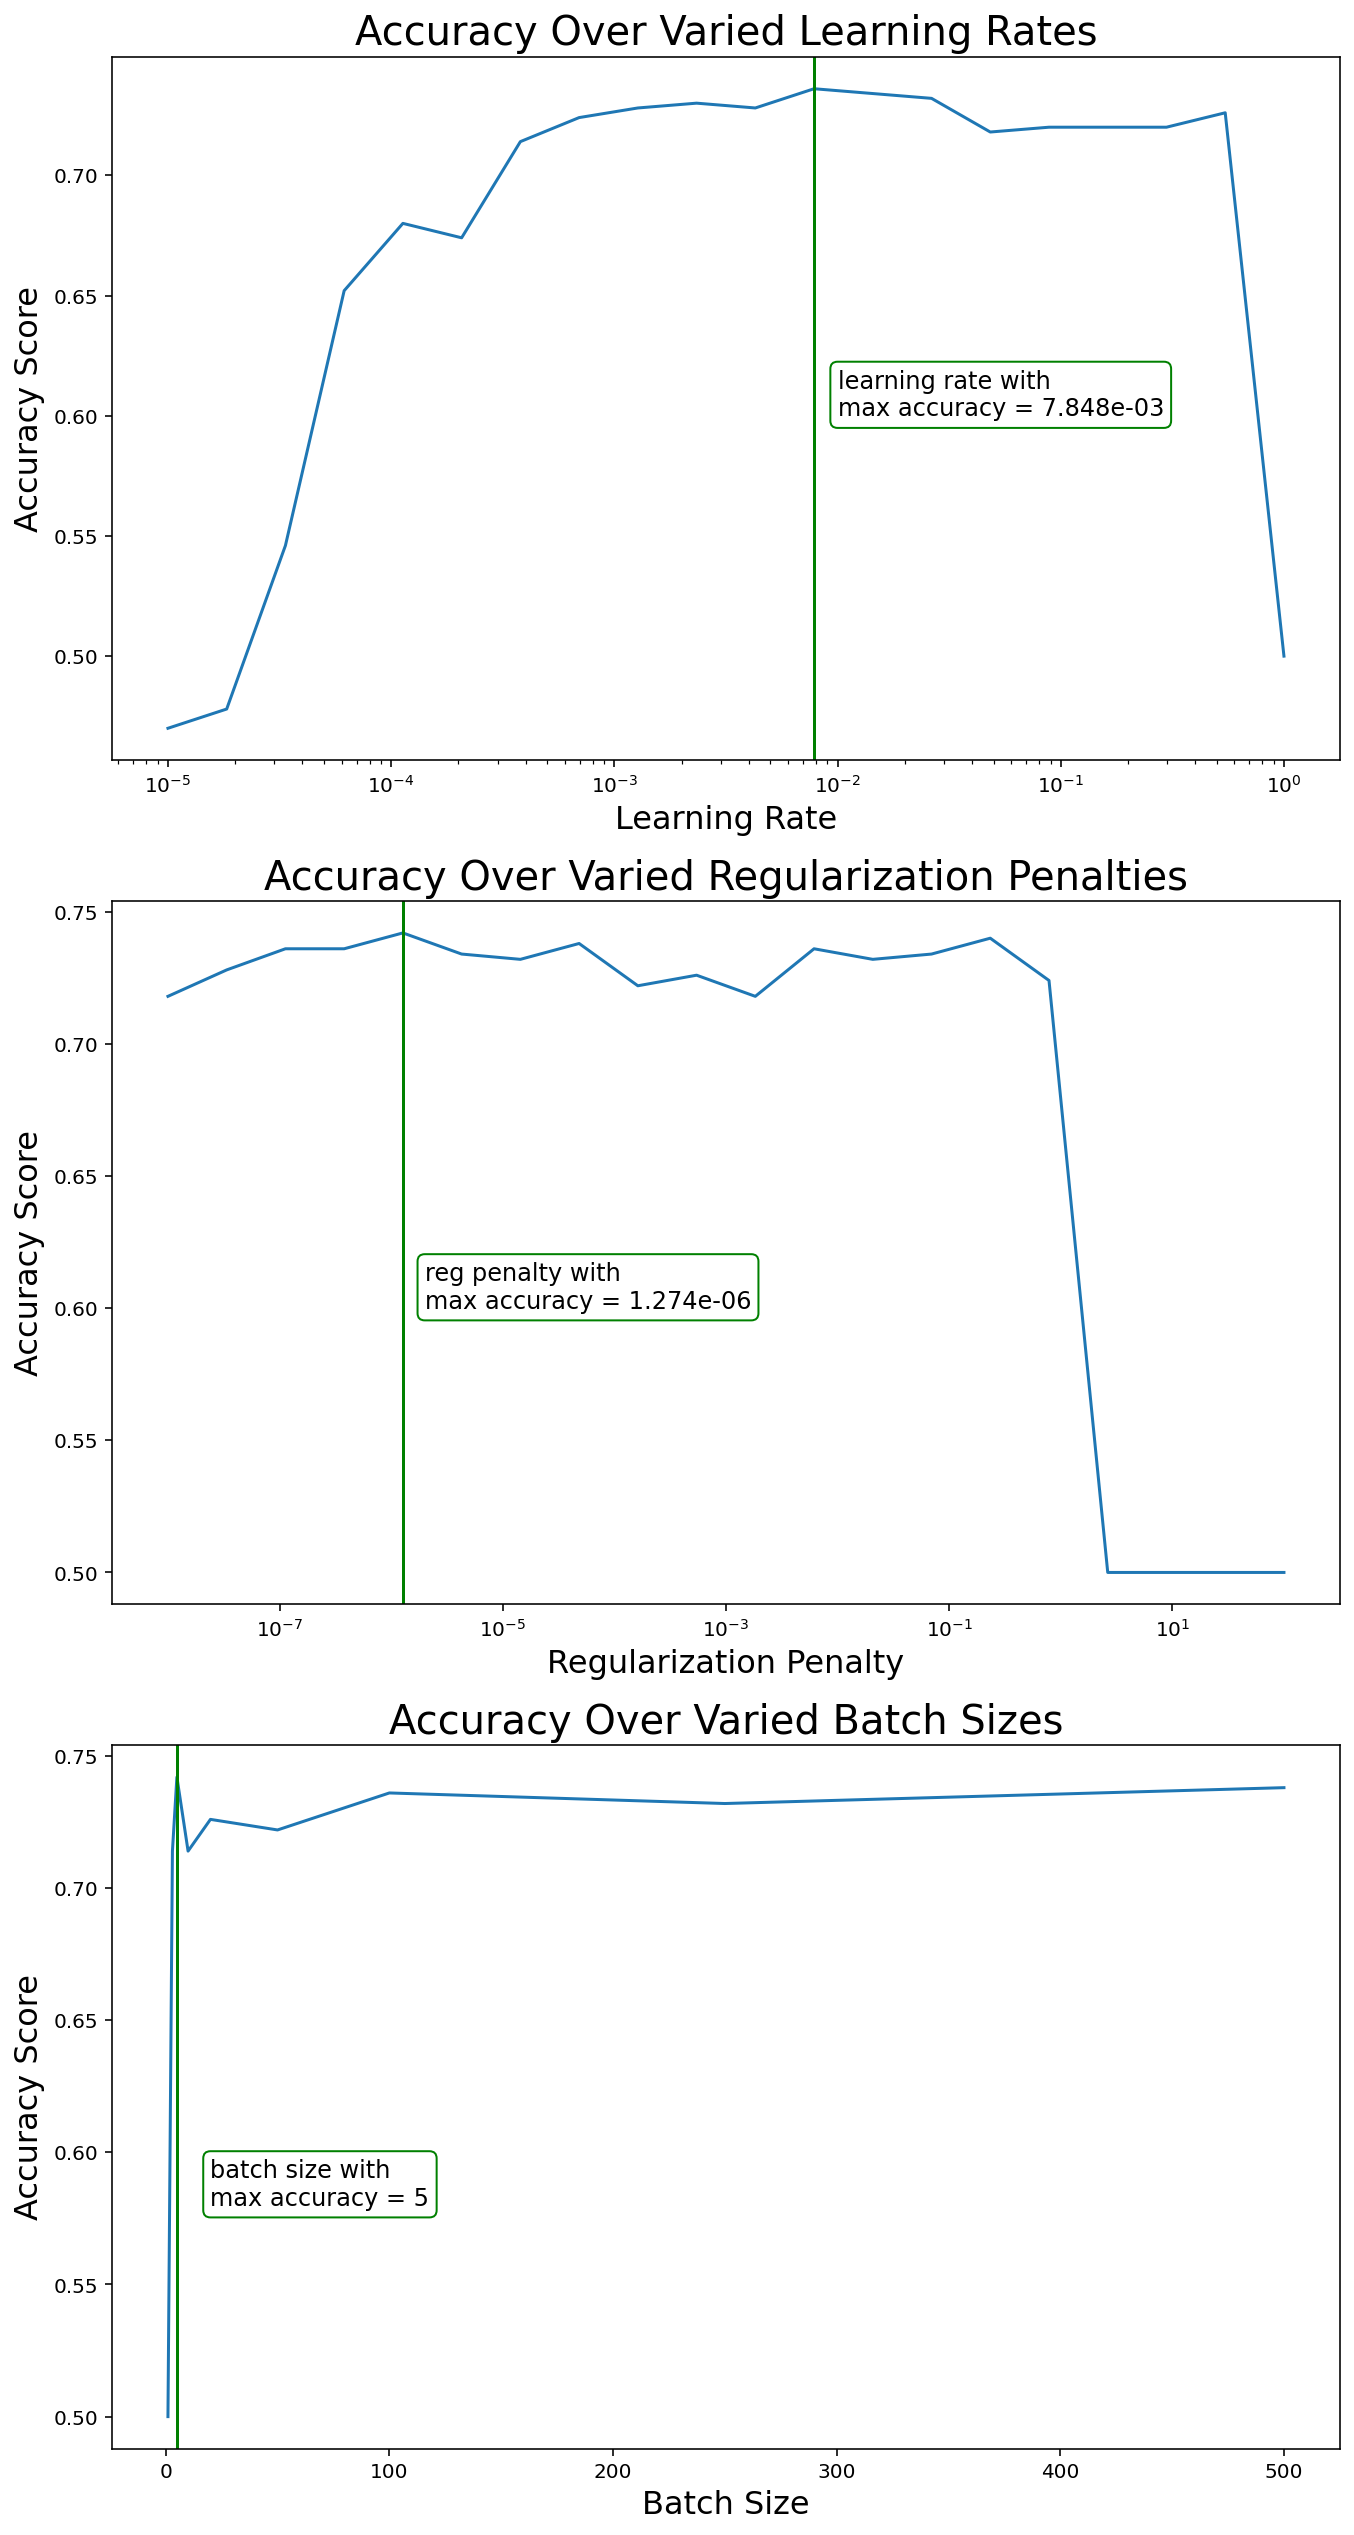

In [14]:
# plotting the three variation processes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 22))
# learning rate
ax1.plot(learning_rates, lr_accuracy_scores)
ax1.set_xscale("log")
ax1.set_title("Accuracy Over Varied Learning Rates", size=20)
ax1.set_xlabel("Learning Rate", size=16)
ax1.set_ylabel("Accuracy Score", size=16)
ax1.axvline(x=learning_rates[np.argmax(lr_accuracy_scores)], color="green")
ax1.text(
    1e-2,
    0.6,
    "learning rate with\nmax accuracy ="
    f" {learning_rates[np.argmax(lr_accuracy_scores)]:.3e}",
    size=12,
    bbox=dict(facecolor="none", edgecolor="green", boxstyle="round"),
)
# regularization penalty
ax2.plot(regularizations, reg_accuracy_scores)
ax2.set_xscale("log")
ax2.set_title("Accuracy Over Varied Regularization Penalties", size=20)
ax2.set_xlabel("Regularization Penalty", size=16)
ax2.set_ylabel("Accuracy Score", size=16)
ax2.axvline(
    x=regularizations[np.argmax(reg_accuracy_scores)], color="green"
)
ax2.text(
    2e-6,
    0.6,
    "reg penalty with\nmax accuracy ="
    f" {regularizations[np.argmax(reg_accuracy_scores)]:.3e}",
    size=12,
    bbox=dict(facecolor="none", edgecolor="green", boxstyle="round"),
)
# batch size
ax3.plot(batch_sizes, batch_accuracy_scores)
ax3.set_title("Accuracy Over Varied Batch Sizes", size=20)
ax3.set_xlabel("Batch Size", size=16)
ax3.set_ylabel("Accuracy Score", size=16)
ax3.axvline(x=batch_sizes[np.argmax(batch_accuracy_scores)], color="green")
ax3.text(
    20,
    0.58,
    "batch size with\nmax accuracy ="
    f" {batch_sizes[np.argmax(batch_accuracy_scores)]}",
    size=12,
    bbox=dict(facecolor="none", edgecolor="green", boxstyle="round"),
)

plt.show()


The chosen hyperparameters moving forward are based upon the value that yields the maximum validation set accuracy, as displayed in the above plots. I used this method to select these values because testing accuracy with a held-out validation set is the best way to tune hyperparameters. Therefore,
- learning rate = $7.848\mathrm{e}{-3}$
- regularization penalty = $1.274\mathrm{e}{-6}$
- batch size = $5$

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture**

In [15]:
# set manually optimized values from above
lr = learning_rates[np.argmax(lr_accuracy_scores)]
reg = regularizations[np.argmax(reg_accuracy_scores)]
batch = batch_sizes[np.argmax(batch_accuracy_scores)]

# number of layers
layers = [1, 2, 3, 4]
# number of nodes per layer
nodes = [1, 2, 3, 4, 5, 10, 15, 25, 30]

all_scores = []

for layer in layers:
    scores_for_layer = []
    for node in nodes:
        mlp = MLPClassifier(
            learning_rate_init=lr,
            hidden_layer_sizes=tuple([node]) * layer,
            alpha=reg,
            solver="sgd",
            tol=1e-5,
            early_stopping=False,
            activation="relu",
            n_iter_no_change=100,
            batch_size=batch,
            max_iter=500,
        ).fit(X_train, y_train)
        scores_for_layer.append(mlp.score(X_val, y_val))
        # print(f"layers = {layer}, nodes per layer = {node}")
        # print(scores_for_layer)
        pass
    all_scores.append(scores_for_layer)
    # print(all_scores)
    pass


In [16]:
layer_labels = [str(i) for i in layers]
node_labels = [str(i) for i in nodes]
scores = np.array(all_scores)


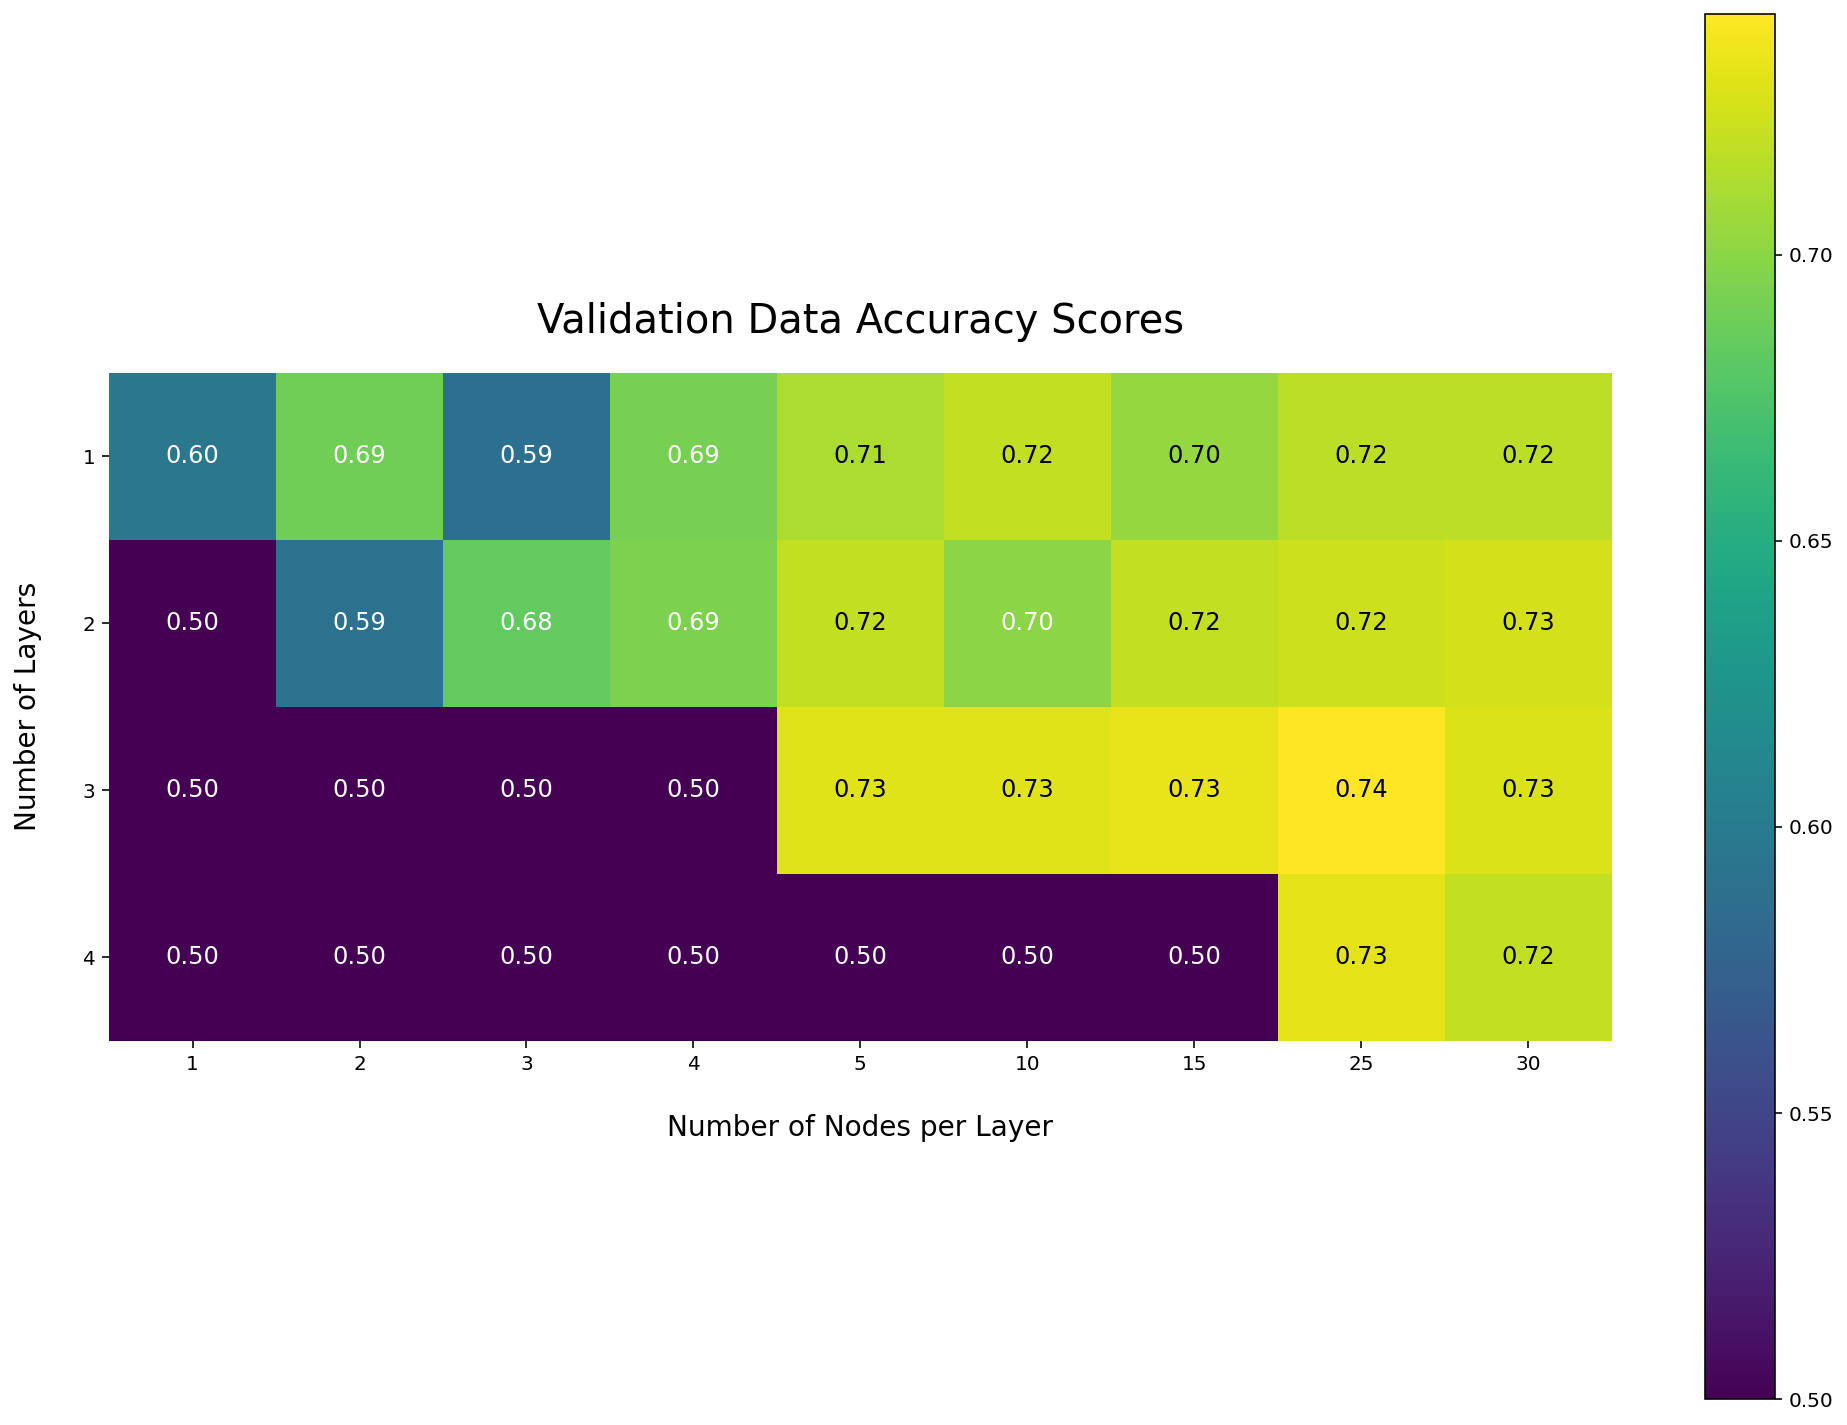

In [17]:
fig, ax = plt.subplots(figsize=(14, 10))

# plot the heatmap
im = ax.imshow(scores)

# create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(node_labels)), labels=node_labels)
ax.set_yticks(np.arange(len(layer_labels)), labels=layer_labels)

# turn spines off
ax.spines[:].set_visible(False)

# loop over data dimensions and create text annotations, color based on value 
# for better readability
for i in range(len(layer_labels)):
    for j in range(len(node_labels)):
        text = ax.text(
            j,
            i,
            f"{scores[i, j]:.2f}",
            ha="center",
            va="center",
            color=("white", "black")[int(scores[i, j] > 0.7)],
            size=12,
        )

plt.xlabel("Number of Nodes per Layer", size=14, labelpad=20)
plt.ylabel("Number of Layers", size=14, labelpad=20)
ax.set_title("Validation Data Accuracy Scores", size=20, pad=20)
fig.tight_layout()
plt.show()


The results show that highest number of nodes per layer yield more accurate validation results when there are more layers. It also appears that increasing the number of layers does not have a great effect on, and indeed may worsen, the validation accuracy. With these observations in mind, we must also account for the fact that these accuracy values may be sensitive to the specific data, i.e., may lead to high variance in larger models. Moving forward, we will use 2 layers with 5 nodes per layer. This combination appears to be the simplest while still potentially leading to high accuracy in a generalized sense.

**(d) Manual (greedy) model selection and retraining.**

In [18]:
# set manually optimized values from above
layer_size = (5, 5)
# retrain on training and validation data
mlp = MLPClassifier(
    learning_rate_init=lr,
    hidden_layer_sizes=layer_size,
    alpha=reg,
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=batch,
    max_iter=500,
).fit(X_train_plus_val, y_train_plus_val)


In [56]:
print(
    "The final manually-set model has an accuracy of"
    f" {mlp.score(X_test, y_test)*100:.2f}% when applied to the testing"
    " data."
)


The final manually-set model has an accuracy of 71.20% when applied to the testing data.


**(e) Automated hyperparameter search through random search.**

In [ ]:
# distribution of parameters to search from
nodelayerlist = [tuple([n]) * l for n in nodes for l in layers]
parameter_distributions = {
    "batch_size": [1, 3, 5, 10, 20, 50, 100, 250, 500],
    "learning_rate_init": loguniform(1e-5, 1e0),
    "alpha": loguniform(1e-8, 1e2),
    "hidden_layer_sizes": nodelayerlist,
}

# build classifier
mlp_random_search = MLPClassifier(
    solver="sgd", tol=1e-5, early_stopping=False, activation="relu"
)

n_iterations = 400
random_search = RandomizedSearchCV(
    mlp_random_search,
    param_distributions=parameter_distributions,
    n_iter=n_iterations,
    n_jobs=-1,
    cv=train_val_split,
)
random_search.fit(X_train_plus_val, y_train_plus_val)


In [65]:
random_search_params = random_search.best_params_
random_search_params


{'alpha': 3.05321886497164e-07,
 'batch_size': 1,
 'hidden_layer_sizes': (10, 10, 10, 10),
 'learning_rate_init': 4.6719418716687514e-05}

Compared to the hyperparameters that were selected through the previous, manual, greedy optimization, these values have the following traits:
- the learning rate is almost 170 times larger than the previous value
- the batch size is fifty times larger than the previous value of 5
- there are twice as many layers in this selection
- there are 4 nodes per layer, which is comparable to the previously chosen value of 5
- the regularization penalty is about 4 times smaller than the previous value

In [66]:
# instantiate new model from random searched hyperparameters
mlp_random_search = MLPClassifier(
    learning_rate_init=random_search_params["learning_rate_init"],
    hidden_layer_sizes=random_search_params["hidden_layer_sizes"],
    alpha=random_search_params["alpha"],
    solver="sgd",
    tol=1e-5,
    early_stopping=False,
    activation="relu",
    n_iter_no_change=100,
    batch_size=random_search_params["batch_size"],
    max_iter=500,
).fit(X_train_plus_val, y_train_plus_val)


In [67]:
print(
    "The final automatically-set model has an accuracy of"
    f" {mlp_random_search.score(X_test, y_test)*100:.2f}% when applied to"
    " the testing data."
)


The final automatically-set model has an accuracy of 72.80% when applied to the testing data.


In [68]:
# calculate metrics from manually set model
fpr_manual, tpr_manual, thresholds_manual = roc_curve(
    y_test, mlp.predict_proba(X_test)[:, 1]
)
auc_manual = auc(fpr_manual, tpr_manual)

# calculate metrics from random search model
fpr_random, tpr_random, thresholds_random = roc_curve(
    y_test, mlp_random_search.predict_proba(X_test)[:, 1]
)
auc_random = auc(fpr_random, tpr_random)


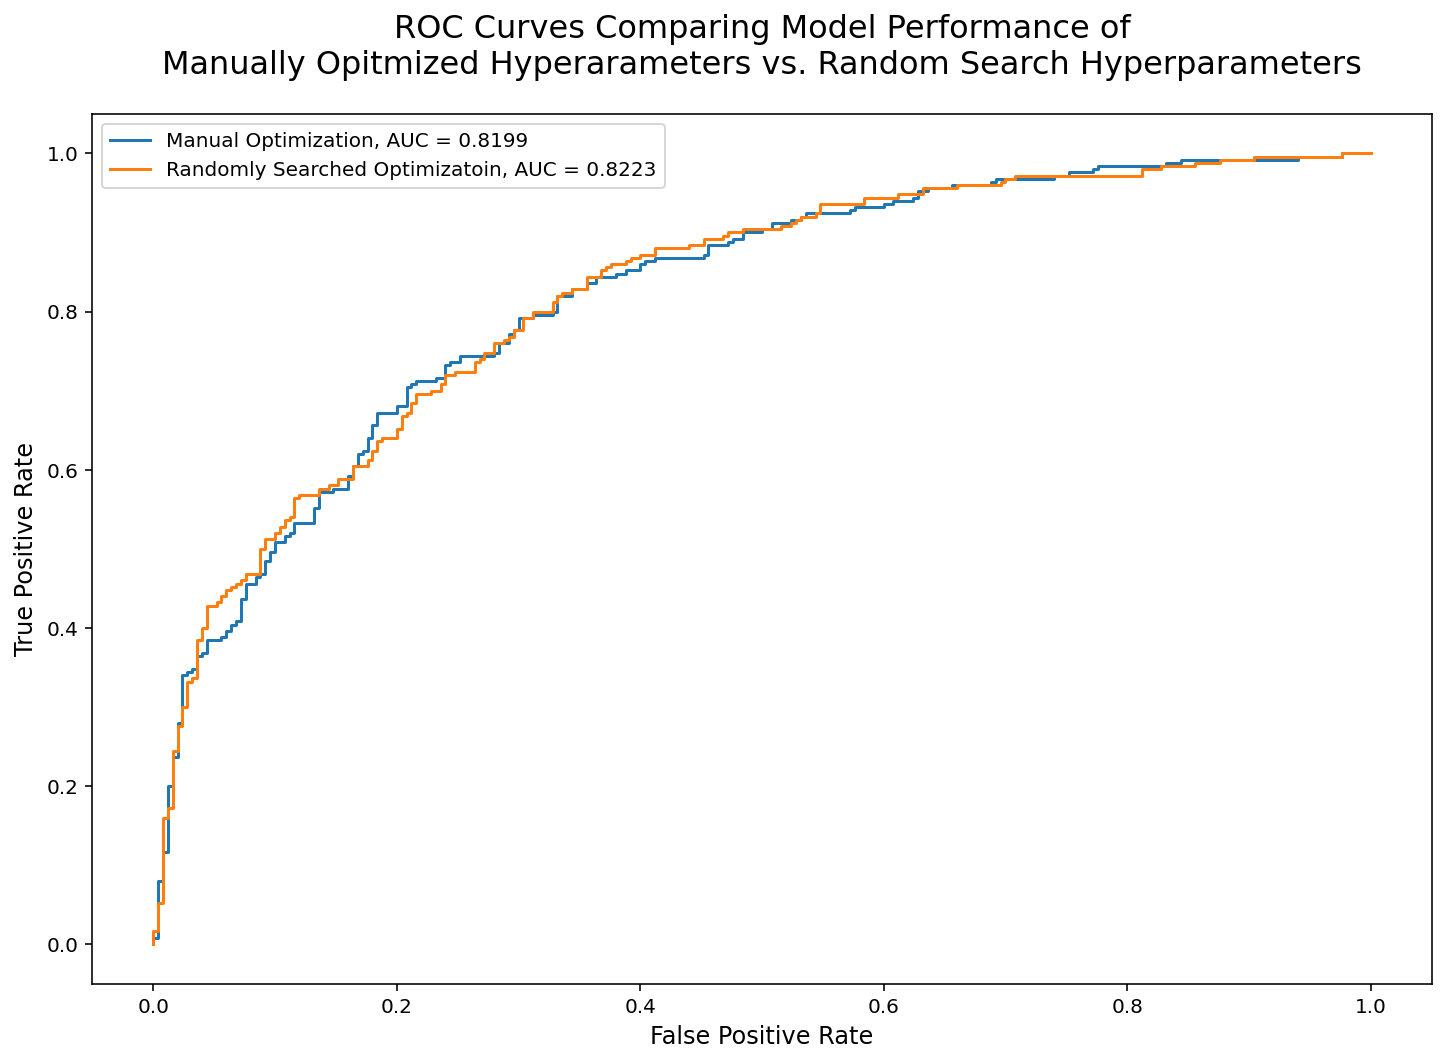

In [74]:
# plot roc for manually set model and random search model
plt.figure(figsize=(12, 8))
# manual metrics
plt.plot(
    fpr_manual,
    tpr_manual,
    label=f"Manual Optimization, AUC = {auc_manual:.4f}",
)
# random metrics
plt.plot(
    fpr_random,
    tpr_random,
    label=f"Randomly Searched Optimizatoin, AUC = {auc_random:.4f}",
)

plt.title(
    "ROC Curves Comparing Model Performance of\nManually Opitmized"
    " Hyperarameters vs. Random Search Hyperparameters",
    size=16,
    pad=20,
)
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.legend()
plt.show()


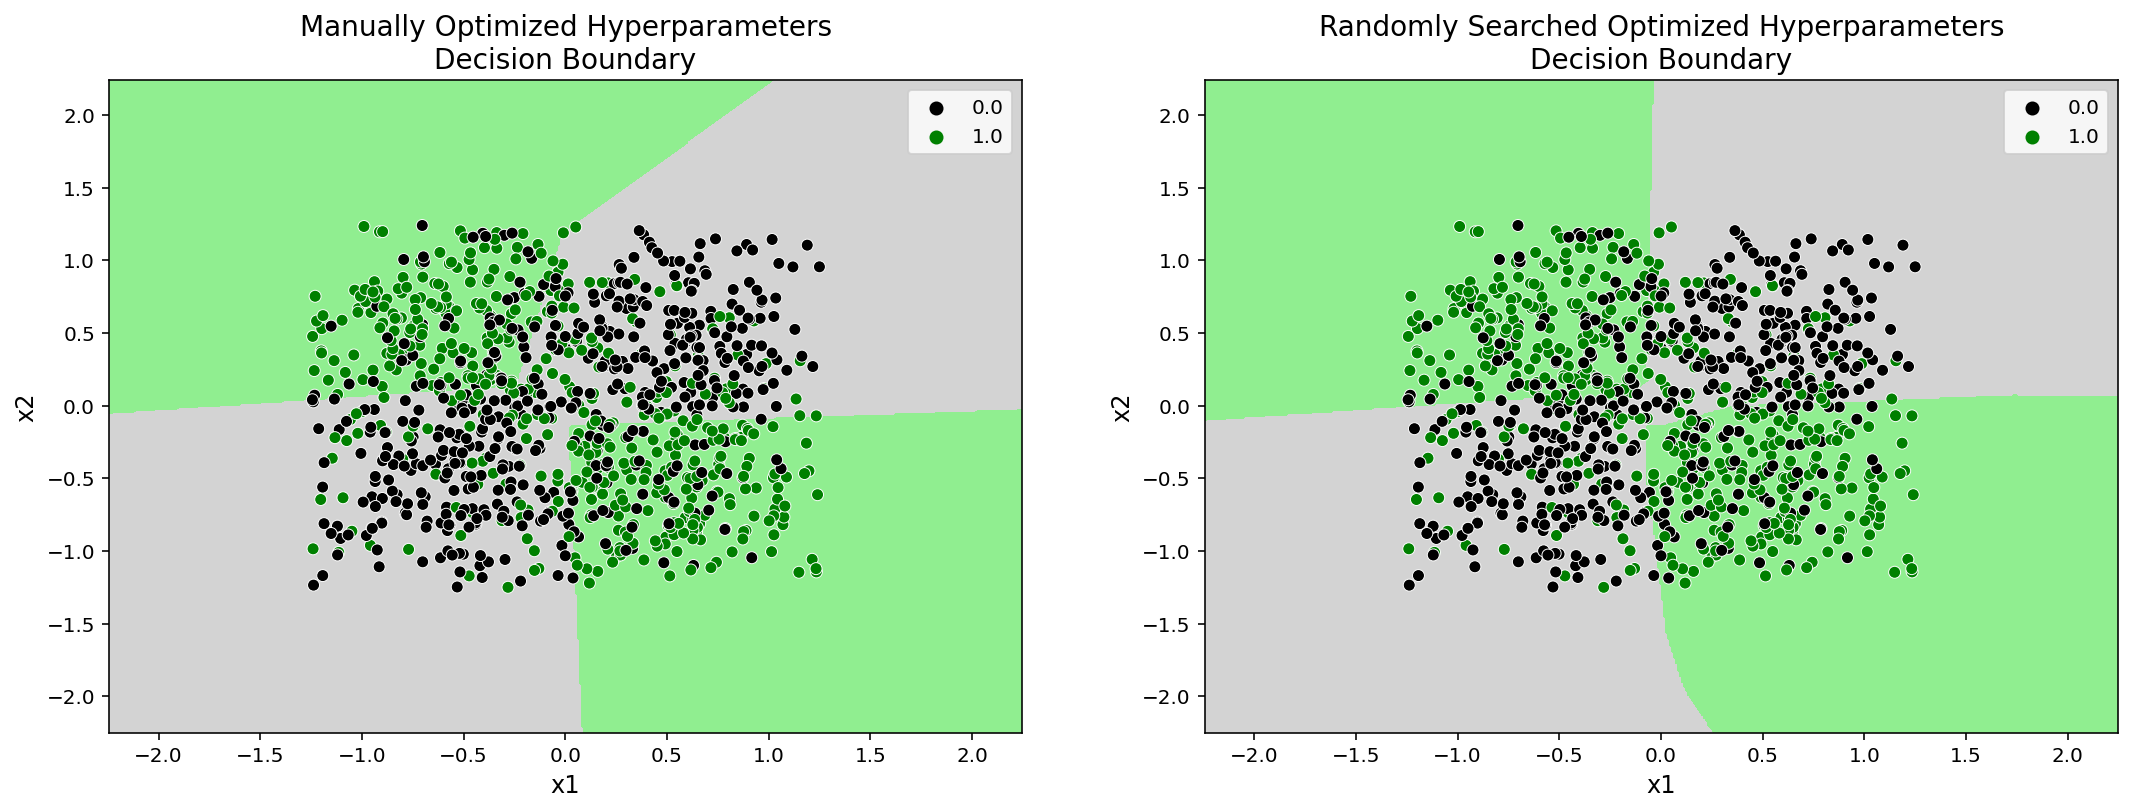

In [75]:
# decision boundaries of final models

# create meshgrid
cmap_light = ListedColormap(["lightgrey", "lightgreen"])
h = 0.01
x1_min, x1_max = (
    X_train_plus_val[:, 0].min() - 1,
    X_train_plus_val[:, 0].max() + 1,
)
x2_min, x2_max = (
    X_train_plus_val[:, 1].min() - 1,
    X_train_plus_val[:, 1].max() + 1,
)
xx1, xx2 = np.meshgrid(
    np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h)
)
Z = np.c_[xx1.ravel(), xx2.ravel()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# decision boundary for manual classifier
manual_bound = mlp.predict(Z).reshape(xx1.shape)
ax1.contourf(xx1, xx2, manual_bound, cmap=cmap_light)
s1 = sns.scatterplot(
    ax=ax1,
    x=X_train_plus_val[:, 0],
    y=X_train_plus_val[:, 1],
    hue=y_train_plus_val,
    palette=["black", "green"],
)
s1.set_title(
    "Manually Optimized Hyperparameters\nDecision Boundary", size=14
)
s1.set_xlabel("x1", size=12)
s1.set_ylabel("x2", size=12)

# decision boundary for automated classifier
random_bound = mlp_random_search.predict(Z).reshape(xx1.shape)
ax2.contourf(xx1, xx2, random_bound, cmap=cmap_light)
s2 = sns.scatterplot(
    ax=ax2,
    x=X_train_plus_val[:, 0],
    y=X_train_plus_val[:, 1],
    hue=y_train_plus_val,
    palette=["black", "green"],
)
s2.set_title(
    "Randomly Searched Optimized Hyperparameters\nDecision Boundary",
    size=14,
)
s2.set_xlabel("x1", size=12)
s2.set_ylabel("x2", size=12)
plt.show()


The generalization perfomance of both classifiers are quite close to each other. With accuracy values of 71.2% and 72.8% and AUC values that both round to 0.82, both classifiers appear to test well generally. Looking at the decision boundaries though, the randomly searched optimized parameter classifier more closely fits to the "checkerboard" shape of the data. That, coupled with a *slightly* higher accuracy lends one to choose it over the manually searched classifier. But this does lead one to believe that with a wider range of values and more processing time, one could create a classifier that performs better than the automatic optimization. 

## 2. SKLearn Classifier Comparison
**(b) Apply scikit-learn neural network and compare to random forest classifier**

In [2]:
# create train, validation, and testing data sets
X_moon, y_moon = make_moons(n_samples=600, noise=0.2)
(
    X_train_val_moon,
    X_test_moon,
    y_train_val_moon,
    y_test_moon,
) = train_test_split(X_moon, y_moon, train_size=500, test_size=100)
X_train_moon, X_val_moon, y_train_moon, y_val_moon = train_test_split(
    X_train_val_moon, y_train_val_moon, train_size=400, test_size=100
)


In [3]:
# define cost function
def cross_entropy(y, pred):
    cost = sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))
    # normalize the cost by sample size
    return -(cost / len(y))


In [4]:
# sklearn neural network classifier
# learning_rates = [1, .01, .001, .0001]

nn_clf_1 = MLPClassifier(
    hidden_layer_sizes=(5, 5),
    learning_rate_init=1,
    activation="logistic",
    solver="sgd",
    tol=1e-10,
    early_stopping=False,
)
nn_clf_01 = MLPClassifier(
    hidden_layer_sizes=(5, 5),
    learning_rate_init=0.01,
    activation="logistic",
    solver="sgd",
    tol=1e-10,
    early_stopping=False,
)
nn_clf_001 = MLPClassifier(
    hidden_layer_sizes=(5, 5),
    learning_rate_init=0.001,
    activation="logistic",
    solver="sgd",
    tol=1e-10,
    early_stopping=False,
)
nn_clf_0001 = MLPClassifier(
    hidden_layer_sizes=(5, 5),
    learning_rate_init=0.0001,
    activation="logistic",
    solver="sgd",
    tol=1e-10,
    early_stopping=False,
)

max_epochs = 5000
n_batches = 100
scores_train_1 = []
scores_val_1 = []
scores_train_01 = []
scores_val_01 = []
scores_train_001 = []
scores_val_001 = []
scores_train_0001 = []
scores_val_0001 = []


In [5]:
# first learning rate
epoch = 0
while epoch < max_epochs:
    # print("epoch: ", epoch)
    # random permutation
    random_permutation = np.random.permutation(X_train_moon.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_permutation[
            mini_batch_index : mini_batch_index + (n_batches - 1)
        ]
        # train model on shuffled data
        nn_clf_1.partial_fit(
            X_train_moon[indices],
            y_train_moon[indices],
            classes=np.unique(y_train_moon),
        )
        mini_batch_index += n_batches - 1
        if mini_batch_index > X_train_moon.shape[0]:
            break
    # calculate cross entropy cost and store
    cost_train = cross_entropy(
        y_train_moon, nn_clf_1.predict_proba(X_train_moon)[:, 1]
    )
    cost_val = cross_entropy(
        y_val_moon, nn_clf_1.predict_proba(X_val_moon)[:, 1]
    )
    scores_train_1.append(cost_train)
    scores_val_1.append(cost_val)
    epoch += 1


In [6]:
# second learning rate
epoch = 0
while epoch < max_epochs:
    # print("epoch: ", epoch)
    # random permutation
    random_permutation = np.random.permutation(X_train_moon.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_permutation[
            mini_batch_index : mini_batch_index + (n_batches - 1)
        ]
        # train model on shuffled data
        nn_clf_01.partial_fit(
            X_train_moon[indices],
            y_train_moon[indices],
            classes=np.unique(y_train_moon),
        )
        mini_batch_index += n_batches - 1
        if mini_batch_index > X_train_moon.shape[0]:
            break
    # calculate cross entropy cost and store
    cost_train = cross_entropy(
        y_train_moon, nn_clf_01.predict_proba(X_train_moon)[:, 1]
    )
    cost_val = cross_entropy(
        y_val_moon, nn_clf_01.predict_proba(X_val_moon)[:, 1]
    )
    scores_train_01.append(cost_train)
    scores_val_01.append(cost_val)
    epoch += 1


In [7]:
# third learning rate
epoch = 0
while epoch < max_epochs:
    # print("epoch: ", epoch)
    # random permutation
    random_permutation = np.random.permutation(X_train_moon.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_permutation[
            mini_batch_index : mini_batch_index + (n_batches - 1)
        ]
        # train model on shuffled data
        nn_clf_001.partial_fit(
            X_train_moon[indices],
            y_train_moon[indices],
            classes=np.unique(y_train_moon),
        )
        mini_batch_index += n_batches - 1
        if mini_batch_index > X_train_moon.shape[0]:
            break
    # calculate cross entropy cost and store
    cost_train = cross_entropy(
        y_train_moon, nn_clf_001.predict_proba(X_train_moon)[:, 1]
    )
    cost_val = cross_entropy(
        y_val_moon, nn_clf_001.predict_proba(X_val_moon)[:, 1]
    )
    scores_train_001.append(cost_train)
    scores_val_001.append(cost_val)
    epoch += 1


In [8]:
# fourth learning rate
epoch = 0
while epoch < max_epochs:
    # print("epoch: ", epoch)
    # random permutation
    random_permutation = np.random.permutation(X_train_moon.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_permutation[
            mini_batch_index : mini_batch_index + (n_batches - 1)
        ]
        # train model on shuffled data
        nn_clf_0001.partial_fit(
            X_train_moon[indices],
            y_train_moon[indices],
            classes=np.unique(y_train_moon),
        )
        mini_batch_index += n_batches - 1
        if mini_batch_index > X_train_moon.shape[0]:
            break
    # calculate cross entropy cost and store
    cost_train = cross_entropy(
        y_train_moon, nn_clf_0001.predict_proba(X_train_moon)[:, 1]
    )
    cost_val = cross_entropy(
        y_val_moon, nn_clf_0001.predict_proba(X_val_moon)[:, 1]
    )
    scores_train_0001.append(cost_train)
    scores_val_0001.append(cost_val)
    epoch += 1


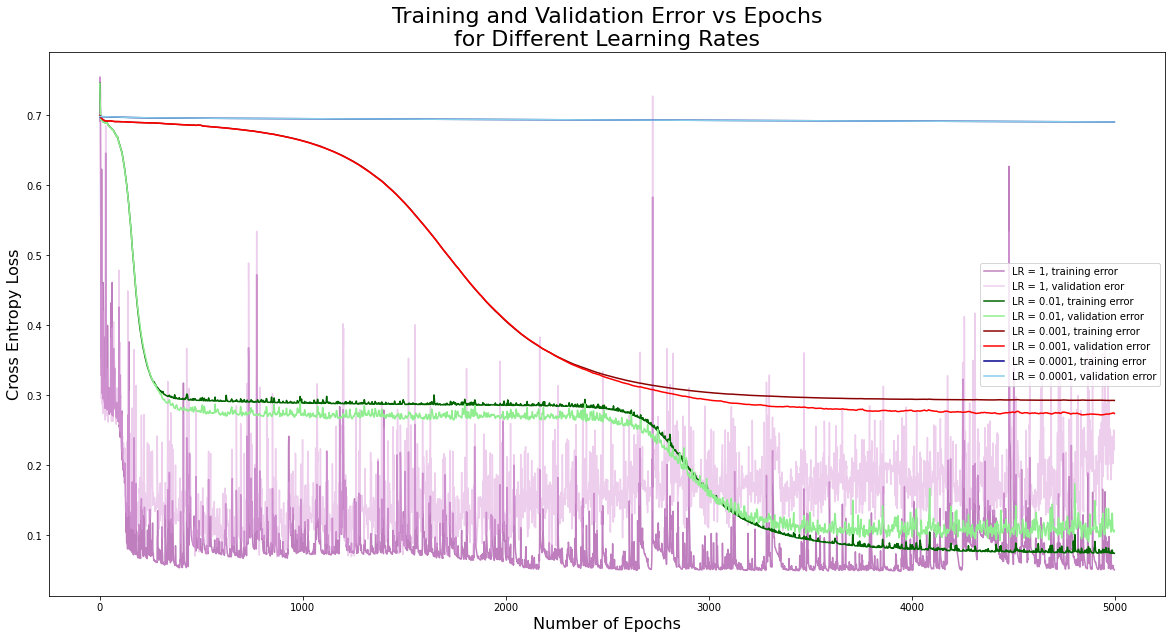

In [9]:
# plot cost over number of epochs, for each of four different learning rates
plt.figure(figsize=(20, 10))

# train and val for lr=1
plt.plot(
    range(max_epochs),
    scores_train_1,
    label="LR = 1, training error",
    color="purple",
    alpha=0.5,
)
plt.plot(
    range(max_epochs),
    scores_val_1,
    label="LR = 1, validation eror",
    color="plum",
    alpha=0.5,
)

# train and val for lr=.01
plt.plot(
    range(max_epochs),
    scores_train_01,
    label="LR = 0.01, training error",
    color="darkgreen",
)
plt.plot(
    range(max_epochs),
    scores_val_01,
    label="LR = 0.01, validation error",
    color="lightgreen",
)

# train and val for lr=.001
plt.plot(
    range(max_epochs),
    scores_train_001,
    label="LR = 0.001, training error ",
    color="darkred",
)
plt.plot(
    range(max_epochs),
    scores_val_001,
    label="LR = 0.001, validation error",
    color="red",
)

# train and val for lr=.0001
plt.plot(
    range(max_epochs),
    scores_train_0001,
    label="LR = 0.0001, training error",
    color="darkblue",
)
plt.plot(
    range(max_epochs),
    scores_val_0001,
    label="LR = 0.0001, validation error",
    color="skyblue",
)

plt.xlabel("Number of Epochs", size=16)
plt.ylabel("Cross Entropy Loss", size=16)
plt.title(
    "Training and Validation Error vs Epochs\nfor Different Learning"
    " Rates",
    size=22,
)
plt.legend()
plt.show()


Based on the above error plot, the optimal learning rate appears to be 0.01 because this value converges the fastest. The cost decreases significantly after about 250 epochs, then converges after 3,000, reaching a decently general minimum at about the 4,000 mark. Thus, I will train the classifier at a learning rate of 0.01 and pass in 4,000 iterations.

In [25]:
best_nn_clf = MLPClassifier(
    hidden_layer_sizes=(5, 5),
    learning_rate_init=0.01,
    activation="logistic",
    solver="sgd",
    tol=1e-10,
    max_iter=4000,
    early_stopping=False,
).fit(X_train_moon, y_train_moon)


/Users/emeliamavis/opt/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(


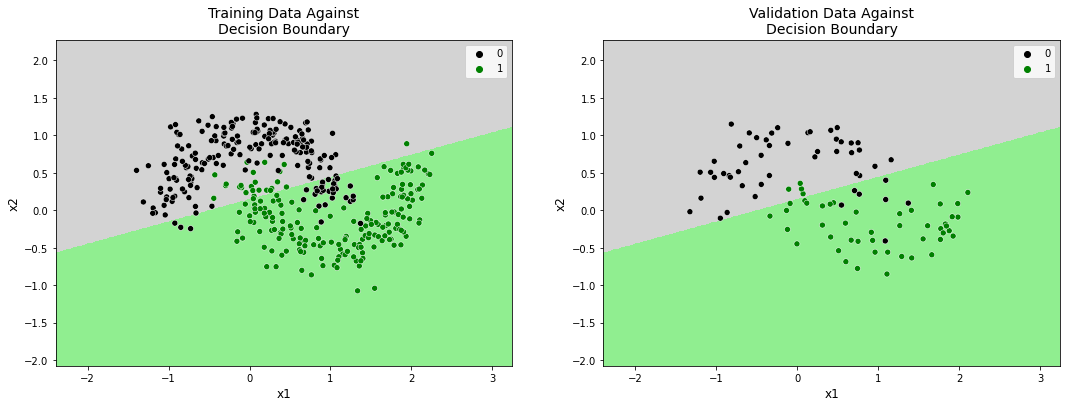

In [26]:
# decision boundary of classifier plotted against training and validation data
# create meshgrid
cmap_light = ListedColormap(["lightgrey", "lightgreen"])
h = 0.01
x1_min, x1_max = (
    X_train_moon[:, 0].min() - 1,
    X_train_moon[:, 0].max() + 1,
)
x2_min, x2_max = (
    X_train_moon[:, 1].min() - 1,
    X_train_moon[:, 1].max() + 1,
)
xx1, xx2 = np.meshgrid(
    np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h)
)
Z = np.c_[xx1.ravel(), xx2.ravel()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# decision boundary for manual classifier
boundary = best_nn_clf.predict(Z).reshape(xx1.shape)
ax1.contourf(xx1, xx2, boundary, cmap=cmap_light)
s1 = sns.scatterplot(
    ax=ax1,
    x=X_train_moon[:, 0],
    y=X_train_moon[:, 1],
    hue=y_train_moon,
    palette=["black", "green"],
)
s1.set_title("Training Data Against\nDecision Boundary", size=14)
s1.set_xlabel("x1", size=12)
s1.set_ylabel("x2", size=12)

ax2.contourf(xx1, xx2, boundary, cmap=cmap_light)
s2 = sns.scatterplot(
    ax=ax2,
    x=X_val_moon[:, 0],
    y=X_val_moon[:, 1],
    hue=y_val_moon,
    palette=["black", "green"],
)
s2.set_title(
    "Validation Data Against\nDecision Boundary",
    size=14,
)
s2.set_xlabel("x1", size=12)
s2.set_ylabel("x2", size=12)
plt.show()


In [27]:
# sklearn default random forest classifier
rf_clf = RandomForestClassifier().fit(X_train_moon, y_train_moon)


In [28]:
# metrics for ROC curve comparing neural network and random forest
fpr_nn, tpr_nn, thresholds_nn = roc_curve(
    y_test_moon, best_nn_clf.predict_proba(X_test_moon)[:, 1]
)
auc_nn = auc(fpr_nn, tpr_nn)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test_moon, rf_clf.predict_proba(X_test_moon)[:, 1]
)
auc_rf = auc(fpr_rf, tpr_rf)


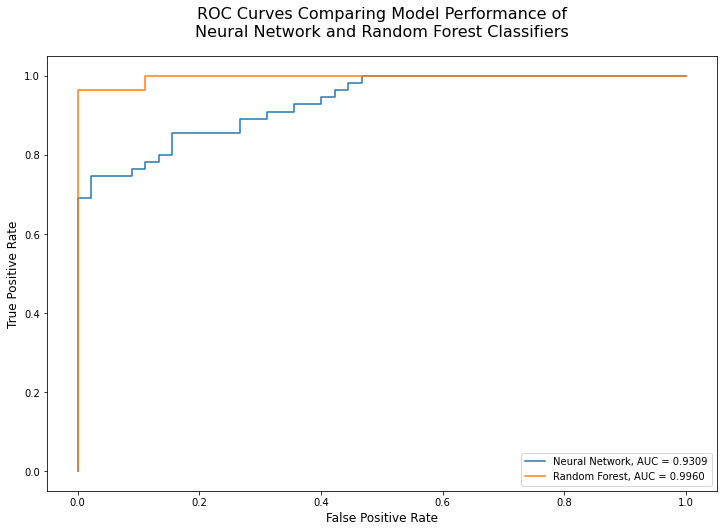

In [29]:
# plot ROC for each classifier
plt.figure(figsize=(12, 8))
# neural network
plt.plot(
    fpr_nn,
    tpr_nn,
    label=f"Neural Network, AUC = {auc_nn:.4f}",
)
# random forest
plt.plot(
    fpr_rf,
    tpr_rf,
    label=f"Random Forest, AUC = {auc_rf:.4f}",
)

plt.title(
    "ROC Curves Comparing Model Performance of\nNeural Network and Random"
    " Forest Classifiers",
    size=16,
    pad=20,
)
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.legend()
plt.show()


**(c)** The first way that the neural network could be improved is a simple one- using more data. If it could be trained on more samples and validated on more samples, the generalization performance would improve. The second way the neural network could improve would be by adding or changing the parameters that would increase it's flexibility. As seen in the decision boundary plots, the classifier remains quite linear, even though the data is not. So adding more layers and activation functions or more nodes could lead the classifier to better fit the data.